# <div align="center"> Titanic - An Statistical Approach

<img src='https://www.ecestaticos.com/imagestatic/clipping/670/a82/670a82a3b2af7462a6ba41f58c38a854.jpg'>

## Content Index

* [1.0 First Approach to the Data](#First)
* [2.0 Descriptive Analysis](#Descrivtive)
* [2.1 Age Distribution](#Age)
* [2.2 Age and Fare](#Fare)
* [2.3 Survivors between features](#Survivors)
* [2.4 What about Family?](#Family)
* [3.0 Dealing with missing values](#Missing)
* [3.1 Age](#MissingAge)
* [3.2 Embarked](#MissingEmbarked)
* [3.3 Cabin](#MissingCabin)
* [4.0 Kids and Women First ?](#bonus)
* [5.0 Unbalanced Classes](#class)
* [6.0 Oversampling](#oversampling)
* [7.0 Developing the Model](#model)
* [8.0 Classification Report](#classification)
    
----------------------------------------------------------------------------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.express as px
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# Loading the DataSet
df = pd.read_csv('train.csv')

### First Approach to the Data <a class="anchor" id="First"></a>

Main metrics

In [3]:
df.describe().transpose()

count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

Null values

In [4]:
pd.DataFrame(df.isnull().sum()/df.shape[0]).rename(columns={0:'% Null Values'}).style.bar( color='#d65f5f')

Analizing the null values, we will have to decide what to do with **"Age"**, **"Cabin"** and **"Embarked"** before to develop a predictive model

### Descriptive Analysis <a class="anchor" id="Descriptive"></a>

In [5]:
df.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

#### Age Distribution <a class="anchor" id="Age"></a>

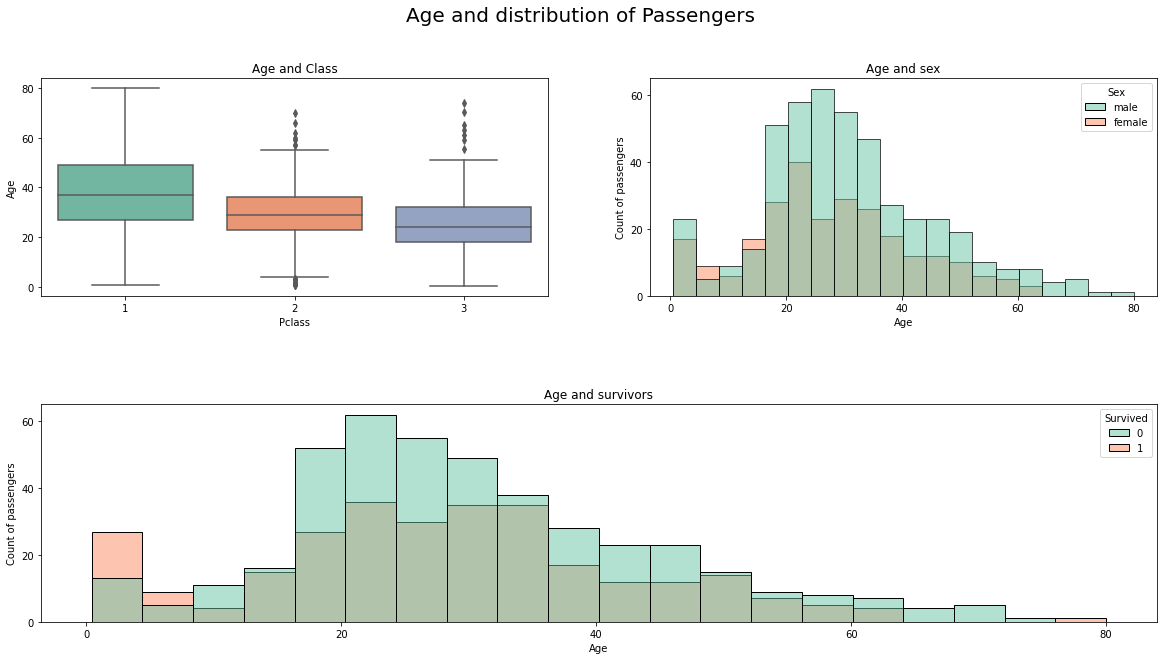

In [6]:
fig = plt.figure(1)
plt.suptitle('Age and distribution of Passengers',fontsize=20)
# set up subplot grid
gridspec.GridSpec(2,2)

# Small subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Age and Class')
plt.xlabel('Age')
plt.ylabel('Pclass')
sns.boxplot(x=df.Pclass,y=df.Age,palette='Set2')

#Small subplot
plt.subplot2grid((2,2), (0,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Age and sex')
plt.xlabel('Age')
plt.ylabel('Count of passengers')
sns.histplot(x=df.Age,hue=df.Sex,palette='Set2')

#Large Plot
plt.subplot2grid((2,2), (1,0), colspan=2, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Age and survivors')
plt.xlabel('Age')
plt.ylabel('Count of passengers')
sns.histplot(x=df.Age,hue=df.Survived,palette='Set2')

#Ajusting plot
fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()


In [7]:
pd.DataFrame(data=[[df.Age.mean(),
        df.loc[df.Survived==0,'Age'].mean(),
        df.loc[df.Survived==1,'Age'].mean()],
        [df.Age.min(),
        df.loc[df.Survived==0,'Age'].min(),
        df.loc[df.Survived==1,'Age'].min()],
        [df.Age.max(),
        df.loc[df.Survived==0,'Age'].max(),
        df.loc[df.Survived==1,'Age'].max()]], index=['Mean Age','Min Age','Max Age'],
             columns=['Global','Not Survivors','Survivors']).round(2)

Global  Not Survivors  Survivors
Mean Age   29.70          30.63      28.34
Min Age     0.42           1.00       0.42
Max Age    80.00          74.00      80.00

#### Age and Fare <a class="anchor" id="Fare"></a>

Text(0.5, 1.0, 'Age and Fare distribution between Survivors')

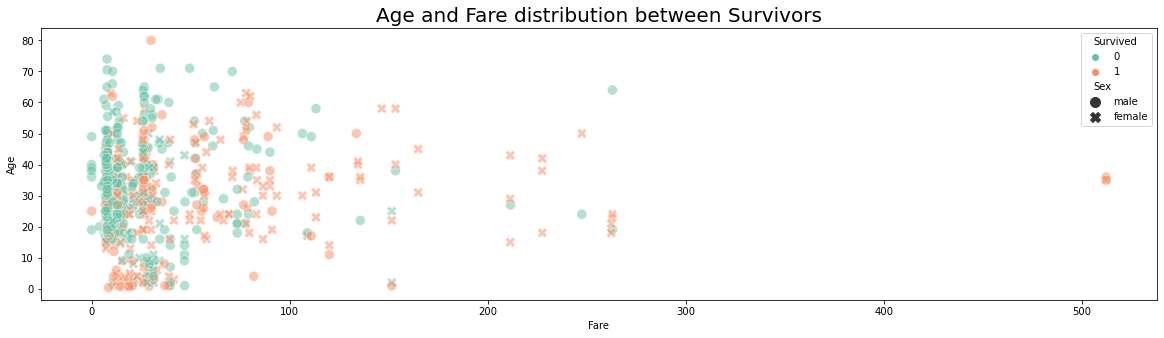

In [8]:
plt.figure(figsize=(20,5))
sns.scatterplot(x='Fare',y='Age',data=df,hue='Survived', style='Sex', alpha=.5, palette="Set2", size='Sex',sizes=(100,100))
plt.title('Age and Fare distribution between Survivors',size=20)

We can notice the follow insights related with the graph:

* We saw older people in the higher classes. That has sense, because higher classes were really expensive and maybe young people couldn't afford that cost.
* Women are younger than men
* The distribution of Age has a global mean at **30 years**. We can notice that between 0 and 15 years we could find **more** survivors, the same happens with the older ages.


#### Survivors between Features  <a class="anchor" id="Survivors"></a>

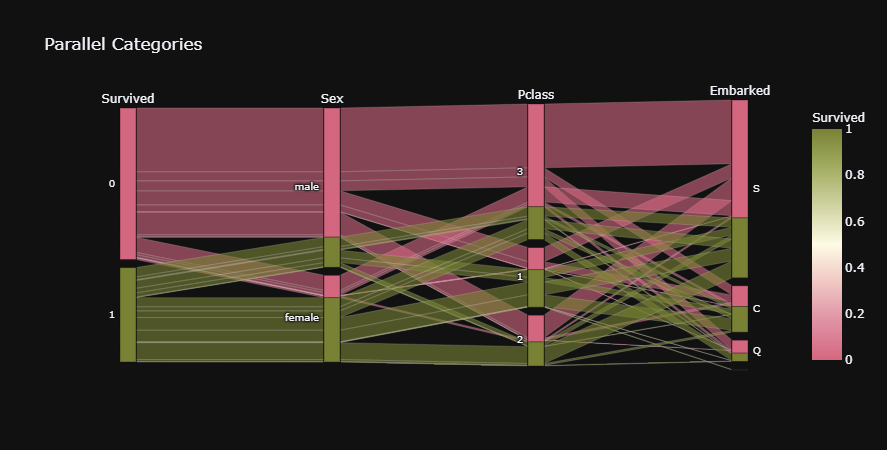

In [9]:
fig = px.parallel_categories(df.loc[:,['Survived','Sex','Pclass','Embarked']], color="Survived", color_continuous_scale='armyrose_r',
                            title='Parallel Categories',template="plotly_dark")
fig.show()

Something intersting about the image, is that we can find a hight percentage of survivors between women and 1 Class

As we could see in the first plot, between the low classes, most of survivors were **kids**.

Another intersting insight, it's that while moving foward to **higher fares**, we ll find more survivors.

### What about Families? <a class="anchor" id="Family"></a>

In [10]:
df['with_sib'] = df.SibSp.apply(lambda x: 'No' if x==0 else 'Yes')
df['with_par'] = df.Parch.apply(lambda x: 'No' if x==0 else 'Yes')

In [11]:
fig = plt.figure(1)
plt.suptitle('Family Analysis',fontsize=20)
# set up subplot grid
gridspec.GridSpec(2,2)

# Small subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('# of parents / children aboard the Titanic')
plt.xlabel('#')
plt.ylabel('count')
sns.countplot(x=df.Parch,hue=df.Survived,palette='Set2')

plt.subplot2grid((2,2), (0,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('# Was he/she with parents/children?')
plt.xlabel('Parents/Children on board')
plt.ylabel('count')
sns.histplot(x=df.with_par,hue=df.Survived,palette='Set2',stat="probability", multiple="fill")

#Large Plot
plt.subplot2grid((2,2), (1,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title(' # of siblings / spouses aboard the Titanic')
plt.xlabel('#')
plt.ylabel('count')
sns.countplot(x=df.SibSp,hue=df.Survived,palette='Set2')

plt.subplot2grid((2,2), (1,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('# Was he/she with Sibilings/Spouses?')
plt.xlabel('Sibilings/Spouses on board')
plt.ylabel('count')
sns.histplot(x=df.with_sib,hue=df.Survived,palette='Set2', multiple="fill",binwidth=0.1)

#Ajusting plot
fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()


As we can see, the passengers who were with their families were more likely to survive (perhaps because of the children).

### Dealing with missing values <a class="anchor" id="Missing"></a>

As we could notice few lines ago, we will have to take some decitions related with what to do with our missing values:
* Age
* Cabin
* Embarked

#### Age <a class="anchor" id="MissingAge"></a>

We only have **19%** of missing values in that feature, and as we noticed, the Age of passengers could be related with the possibilities of survive.
Because of that, it could be a good idea to fill that feature in some way, for using after in our model.

The main question is: 
* ¿How can we predict the Age of a Passenger?
* ¿Do we have features with high correlation between Age?

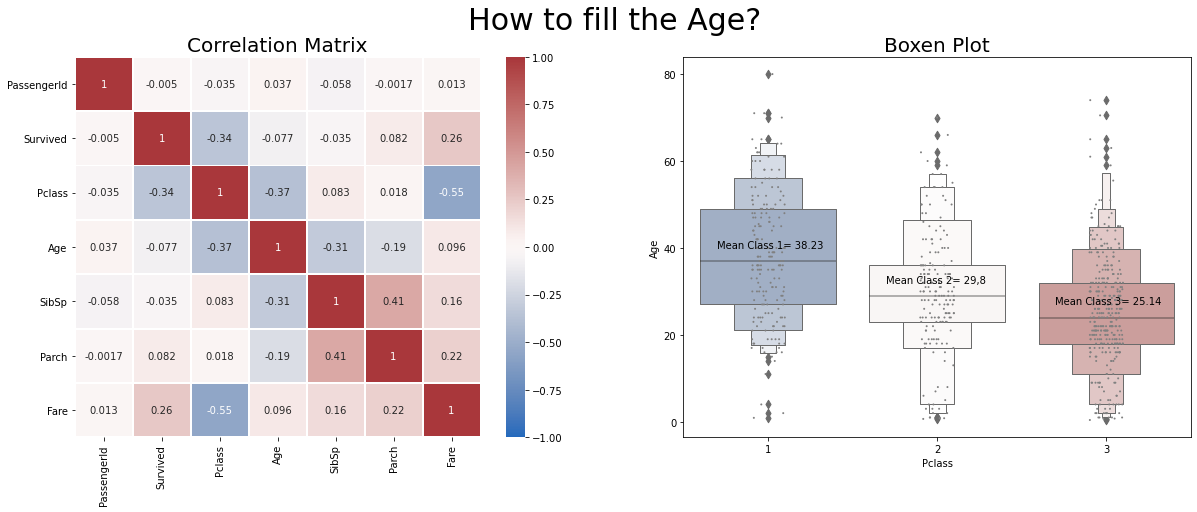

In [12]:
fig= plt.figure(1)
plt.suptitle('How to fill the Age?',fontsize=30)
# set up subplot grid
gridspec.GridSpec(1,2)

# 1 subplot
plt.subplot2grid((1,2), (0,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Correlation Matrix',size=20)
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='vlag', linecolor='white',linewidths=1)

# 2 subplot
plt.subplot2grid((1,2), (0,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Boxen Plot',size=20)
plt.annotate("Mean Class 2= 29,8", xy=(0.7,32))
plt.annotate("Mean Class 1= 38.23", xy=(0,40),xytext=(-0.3,40))
plt.annotate("Mean Class 3= 25.14", xy=(1.7,27))
sns.boxenplot(x=df.Pclass,y=df.Age,palette='vlag')
sns.stripplot(x=df.Pclass,y=df.Age,
              size=2, color="grey", linewidth=0)

#Ajusting plot
fig.set_size_inches(w=20,h=7)
plt.subplots_adjust(hspace=.5)
plt.show()


Like in the very beginning of our analize, we notice that **higher classes** are related with **higher Ages**. Due of that issue, we will fill the missing Ages, with the mean of the Pclass related with each of them.

Example of the code

```js
for x in range(1,4): #Because we have 3 classes
    df.loc[df.Pclass==x,['Age']] = df.loc[df.Pclass==x,['Age']].fillna(value=df.loc[df.Pclass==x,['Age']].mean().round(1))

```

In [13]:
#df.loc[df.Pclass==1,['Age']] = df.loc[df.Pclass==1,['Age']].fillna(value=38.23)
#df.loc[df.Pclass==2,['Age']] = df.loc[df.Pclass==2,['Age']].fillna(value=29.8)
#df.loc[df.Pclass==3,['Age']] = df.loc[df.Pclass==3,['Age']].fillna(value=25.14)

In [14]:
for x in range(1,4):
    df.loc[df.Pclass==x,['Age']] = df.loc[df.Pclass==x,['Age']].fillna(value=df.loc[df.Pclass==x,['Age']].mean().round(1))

In [15]:
pd.DataFrame(df.isnull().sum()/df.shape[0]).rename(columns={0:'% Null Values'}).style.bar( color='#d65f5f')

#### Embarked <a class="anchor" id="MissingEmbarked"></a>

It is the port of where passengers came.

Could we found the most common port and use it to replae the missing values?

In [16]:
plt.figure(figsize=(20,5))
#sns.countplot(y=df.Embarked,palette='vlag')
#plt.title('Embark port', size=20)

splot = sns.countplot(data=df, x = 'Embarked',palette='vlag')
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Ports and Passengers', size=20)
plt.ylim([0, 1000])

(0.0, 1000.0)

In [17]:
df.loc[:,['Embarked']] = df.loc[:,['Embarked']].fillna(value='S')

In [18]:
pd.DataFrame(df.isnull().sum()/df.shape[0]).rename(columns={0:'% Null Values'}).style.bar( color='#d65f5f')

#### Cabin <a class="anchor" id="MissingCabin"></a>

Analysing the last conflictive feature "Cabin", we notice that we have **so many missing values**. Because we won't introduce so much bias in our dataset, we decided to **delete** the whole feature.

In [19]:
df = df.drop(axis=1,  columns='Cabin')

In [20]:
pd.DataFrame(df.isnull().sum()/df.shape[0]).rename(columns={0:'% Null Values'}).style.bar( color='#d65f5f')

### Kids and women first? <a class="anchor" id="bonus"></a>

We perfectly know the famous phrase: "Women and Kids first !! " in apocalyptical movies. 
It was true with the Titanic population?

Due to make a brief analysis, we will create a new feature (only for this particular thing) called : Who, which takes the value Kid, Men or Women depending of the passenger.

In [21]:
df['Luck'] = df.Survived.apply(lambda x: 'Survivor' if x ==1 else 'Not Lucky')

In [22]:
df.loc[df.Sex=='female','Who'] = 'Women'

In [23]:
df.loc[df.Sex=='male','Who'] = 'Men'

In [24]:
df.loc[df.Age<=16,'Who'] = 'Kid'

In [64]:
import plotly
fig = px.sunburst(df, path=['Who','Pclass', 'Luck'],color_discrete_map={'Survivor':'green','Not Lucky':'pink','Men':'black'},
                  template='plotly_dark',
                  title="Lucky Passengers",
                  width=750, height=750, branchvalues='total')
fig.update_traces(textinfo="label + percent parent")
fig.show()

If you play with the previous graph, you could notice that:
* Most probably survivors were Women and Kids
* Most probably survivors werer from first class

So, maybe the sentence "Women and kids first" was true, at least in Titanic

### Unbalanced Classes <a class="anchor" id="class"></a>

Before choose and train an algorithm, we want to see if our dataset is or not balanced.
Following that, we will plot our feature (survived) in our train set.

(0.0, 1000.0)

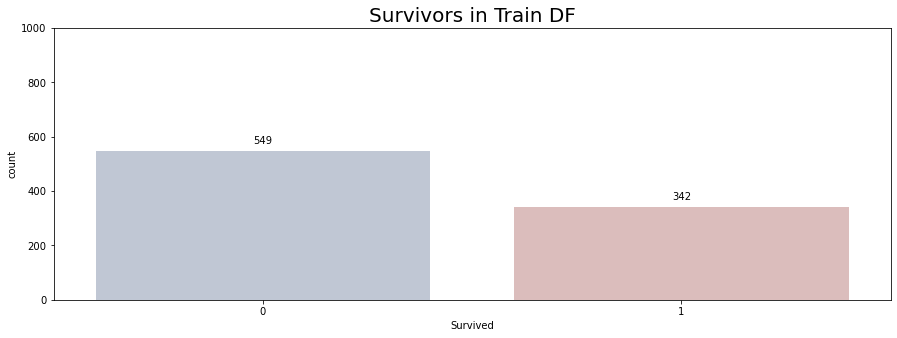

In [31]:
plt.figure(figsize=(15,5))
#sns.countplot(y=df.Embarked,palette='vlag')
#plt.title('Embark port', size=20)

splot = sns.countplot(data=df, x = 'Survived',palette='vlag')
for p in splot.patches:
  splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Survivors in Train DF', size=20)
plt.ylim([0, 1000])

In [32]:
df['Pclass'] = df.Pclass.astype('str')

In [33]:
X_train= df[['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked']]
y_train= df.Survived

### Oversampling <a class="anchor" id="oversampling"></a>

In [34]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('training set:')
print(y_train_os.value_counts())


training set:
1    549
0    549
Name: Survived, dtype: int64


In [35]:
X_train_os = pd.get_dummies(X_train_os,drop_first=True)

In [36]:
X_train_os.head(2)

Age  SibSp  Parch     Fare  Pclass_2  Pclass_3  Sex_male  Embarked_Q  \
0  22.0      1      0   7.2500         0         1         1           0   
1  38.0      1      0  71.2833         0         0         0           0   

   Embarked_S  
0           1  
1           0

### Developing the model <a class="anchor" id="model"></a>

In [37]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

In [39]:
# we create a function to evaluate our model
def model_performance(model, name, X, y, cv):
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print("Performance of {}:\t{:0.3} ± {:0.3}".format( \
        name, s.mean().round(3), s.std().round(3)))

In [40]:
gb_os = GradientBoostingClassifier()
model_performance(gb_os, "GradientBoostingClassifier", X_train_os, y_train_os, cv)

Performance of GradientBoostingClassifier:	0.844 ± 0.031


In [41]:
from sklearn.model_selection import GridSearchCV


In [42]:
params_gb_os = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.001, 0.1],
            'max_depth' : [1, 2, 3, 4]}

grid_gb_os = GridSearchCV(gb_os, param_grid=params_gb_os, cv=cv, verbose=1, n_jobs=3)

In [43]:
grid_gb_os.fit(X_train_os, y_train_os)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   15.1s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:   39.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=3,
             param_grid={'learning_rate': [0.001, 0.001, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [44]:
model_performance(grid_gb_os.best_estimator_, "GradientBoostingClassifier", X_train_os, y_train_os, cv)

Performance of GradientBoostingClassifier:	0.864 ± 0.02


In [45]:
model_os = grid_gb_os.best_estimator_
model_os

GradientBoostingClassifier(max_depth=4, n_estimators=1000)

In [46]:
importances_os = model_os.feature_importances_

In [47]:

indices = np.argsort(importances_os)[::-1]


names = X_train_os.columns[indices]

plt.figure(figsize=(15,7))


plt.title("Feature Importance")

plt.bar(range(X_train_os.shape[1]), importances_os[indices])

plt.xticks(range(X_train_os.shape[1]), names, rotation=90)


plt.show()

In [48]:
y_pred=grid_gb_os.best_estimator_.predict(X_train_os)

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

### Clasification Report <a class="anchor" id="classification"></a>

In [50]:
print(classification_report(y_train_os, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       549
           1       0.98      0.99      0.98       549

    accuracy                           0.98      1098
   macro avg       0.98      0.98      0.98      1098
weighted avg       0.98      0.98      0.98      1098



Text(0.5, 1.0, 'Confusion Matrix of Train Set')

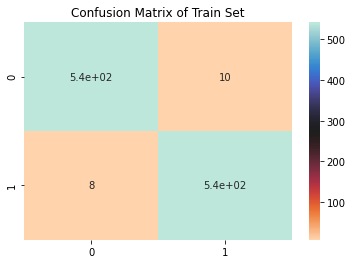

In [51]:
sns.heatmap(confusion_matrix(y_train_os, y_pred), annot=True, cmap='icefire_r')
plt.title('Confusion Matrix of Train Set')

In [52]:
from scikitplot.metrics import plot_roc

plot_roc(y_train_os,grid_gb_os.predict_proba(X_train_os))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

## Predicting new values

In [166]:
df_test = pd.read_csv('test.csv')

In [167]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [168]:
pd.DataFrame(df_test.isnull().sum()/df_test.shape[0]).rename(columns={0:'% Null Values'}).style.bar( color='#d65f5f')

In [169]:
for x in range(1,4):
    df_test.loc[df_test.Pclass==x,['Age']] = df_test.loc[df_test.Pclass==x,['Age']].fillna(value=df_test.loc[df_test.Pclass==x,['Age']].mean().round(1))
    

In [170]:
df_test.loc[:,['Embarked']] = df_test.loc[:,['Embarked']].fillna(value='S')

In [171]:
df_test = df_test.drop(axis=1,  columns='Cabin')

In [172]:
for x in range(1,4):
    df_test.loc[df_test.Pclass==x,['Fare']] = df_test.loc[df_test.Pclass==x,['Fare']].fillna(value=df_test.loc[df_test.Pclass==x,['Fare']].mean().round(1))
    

In [173]:
df_test['Pclass'] = df_test.Pclass.astype('str')

In [174]:
X_test= df_test[['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked']]


In [175]:
X_test = pd.get_dummies(X_test)

In [178]:
X_train_os.head(2)

Age  SibSp  Parch     Fare  Pclass_2  Pclass_3  Sex_male  Embarked_Q  \
0  22.0      1      0   7.2500         0         1         1           0   
1  38.0      1      0  71.2833         0         0         0           0   

   Embarked_S  
0           1  
1           0

In [179]:
X_test = X_test.drop(columns=['Pclass_1','Sex_female','Embarked_C'])

In [180]:
y_test_pred=grid_gb_os.best_estimator_.predict(X_test)

In [181]:
df_test['Survived']= y_test_pred

In [182]:
submission = df_test[['PassengerId','Survived']].set_index('PassengerId')

In [183]:
submission.to_csv('submission.csv')

<img src='https://www.nextlevelenglish.pe/wp-content/uploads/2019/07/Dise%C3%B1o-sin-t%C3%ADtulo-1024x576.png'>